In [6]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Code tutorial for inverse probelms
J. Sulam
"""

# Basic imports
from pathlib import Path
import numpy as np
from imageio.v3 import imread
import matplotlib.pyplot as plt

%matplotlib inline
import pywt
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Loading image

img_path = Path("galaxy.jpg")
if not img_path.exists():
    raise FileNotFoundError(
        "Could not find 'galaxy.png' in the current folder. "
        "Place the image next to the notebook and re-run."
    )

# Read the image; keep as float32 in range [0, 255]
x0_raw = imread(img_path)

# Read the image; keep as float32 in range [0, 255]
x0_raw = imread(img_path)

# Convert to float32 and scale to [0,1]
if np.issubdtype(x0_raw.dtype, np.integer):
    x0 = x0_raw.astype(np.float32) / 255.0
else:
    x0 = x0_raw.astype(np.float32)
    # If the image was already in [0,255], rescale; otherwise assume it's already in [0,1]
    vmax = np.max(x0)
    if vmax > 1.5:
        x0 = x0 / 255.0

print(f"x0 shape: {x0.shape}, dtype: {x0.dtype}, min/max: {x0.min():.2f}/{x0.max():.2f}")



x0 shape: (1428, 1730, 3), dtype: float32, min/max: 0.00/1.00


MSE: 0.046508, PSNR: 13.32 dB SSIM: 0.5963


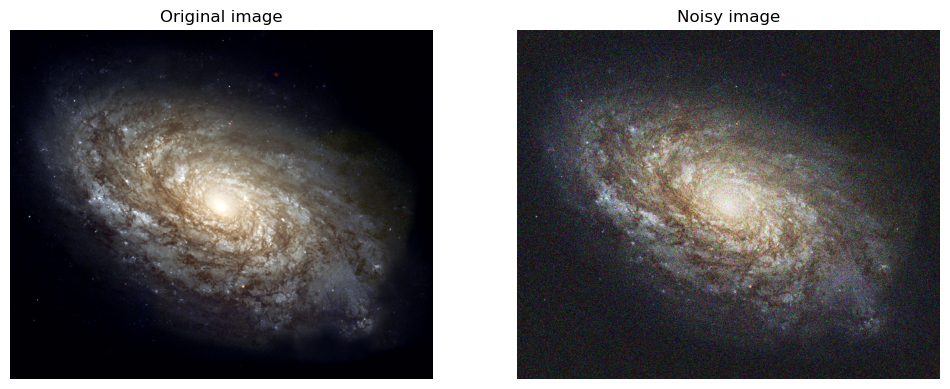

In [8]:
# Step 2: Create noisy version y with Gaussian noise (σ ≈ 20 on [0,255] scale → 0.078 on [0,1])

rng = np.random.default_rng(42)
sigma = 70.0 / 255.0  # noise std on [0,1] scale
noise = rng.normal(loc=0.0, scale=sigma, size=x0.shape).astype(np.float32)

y = np.clip(x0 + noise, 0.0, 1.0)

# define mse function and psnr function
def mse(a, b):
    return float(np.mean((a - b)**2))

def psnr(a, b, data_range=1.0):
    m = mse(a, b)
    if m == 0:
        return float('inf')
    return 10.0 * np.log10((data_range**2) / m)

# import SSIM from skimage and adjust win_size parameter
from skimage.metrics import structural_similarity as ssim
# Calculate SSIM with appropriate parameters
win_size = min(x0.shape[0], x0.shape[1]) if min(x0.shape[0], x0.shape[1]) % 2 == 1 else min(x0.shape[0], x0.shape[1]) - 1
ssim_value = ssim(x0, y, data_range=1.0, win_size=win_size, channel_axis=-1)

print(f"MSE: {mse(x0, y):.6f}, PSNR: {psnr(x0, y):.2f} dB", f"SSIM: {ssim_value:.4f}")

# Display noisy image next to original
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(x0)
plt.axis("off")
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.imshow(y)
plt.axis("off")
plt.title(f"Noisy image")
plt.show()

### Tikhonov (L2) regularization
In the **Tikhonov (L2) regularization** model, we recover a clean image $x$ from a noisy observation $y  by solving:

$$\min_{x} \; \| y - x \|_2^2 \;+\; \lambda \| x \|_2^2$$

where the first term $\| y - x \|_2^2$ enforces **data fidelity**, keeping the denoised image close to the noisy observation, and the second term $\lambda \| x \|_2^2 $ penalizes large pixel intensities, promoting smoothness and reducing noise. The parameter $\lambda > 0$ balances between **noise removal** (larger $\lambda $) and **detail preservation** (smaller $\lambda $).

Because the problem is **quadratic and convex**, it has a closed-form solution obtained by setting the gradient to zero:

$$
( I + \lambda I ) x^\star = y
\quad\Rightarrow\quad
x^\star = \frac{1}{1+\lambda} \, y
$$

Hence, Tikhonov denoising simply **shrinks** all pixel values toward zero by a constant factor $1 / (1 + \lambda) $.  
This provides a simple baseline, though it tends to oversmooth details and edges.

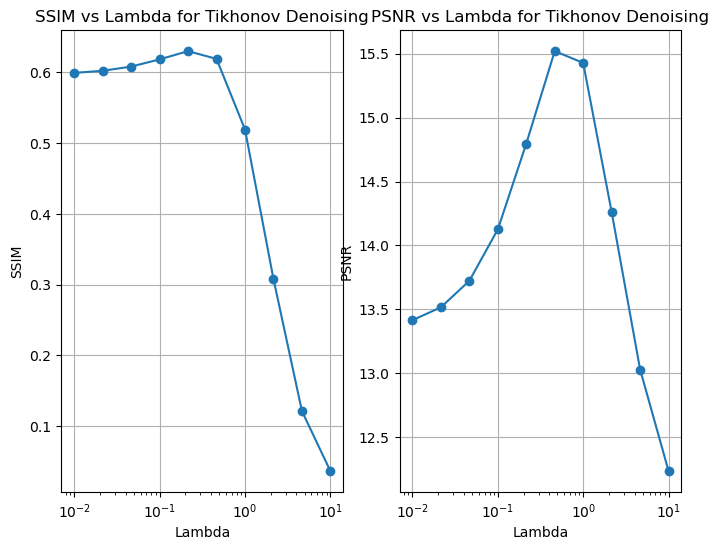

Best lambda: 0.46415888336127775, MSE: 0.028049, PSNR: 15.52 dB, SSIM: 0.6188


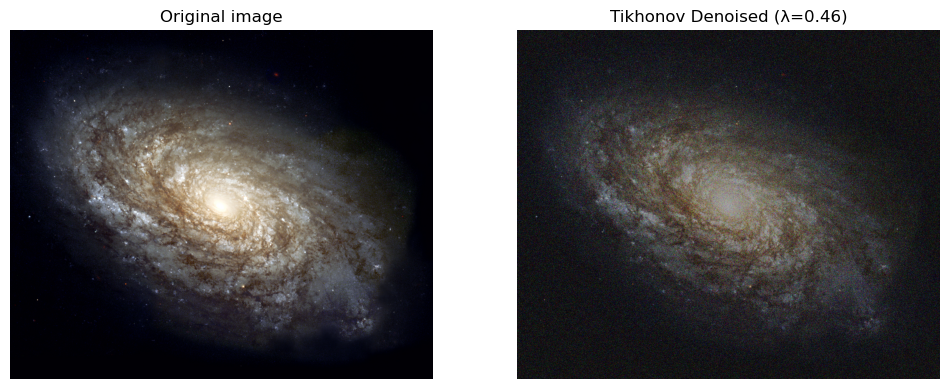

In [ ]:
# Implementing L2 Tikhonov denoising


# Choose a set of lambdas to try in log scale
lambdas = np.logspace(-2, 1, num=10)

tik_results = []
for lam in lambdas:
    x_tik = y / (1.0 + lam)              # closed form
    x_tik = np.clip(x_tik, 0.0, 1.0)     # keep in [0,1] for safety
    err_mse = mse(x_tik, x0)
    err_psnr = psnr(x_tik, x0, data_range=1.0)
    err_ssim = ssim(x_tik, x0, data_range=1.0, win_size=win_size, channel_axis=-1)
    tik_results.append({"lambda": lam, "x": x_tik, "mse": err_mse, "psnr": err_psnr, "ssim": err_ssim})

# Plot err_ssim vs lambda
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.semilogx([r["lambda"] for r in tik_results], [r["ssim"] for r in tik_results], marker='o')
plt.xlabel("Lambda")
plt.ylabel("SSIM")
plt.title("SSIM vs Lambda for Tikhonov Denoising")
plt.grid(True)
plt.subplot(1, 2, 2)
plt.semilogx([r["lambda"] for r in tik_results], [r["psnr"] for r in tik_results], marker='o')
plt.xlabel("Lambda")
plt.ylabel("PSNR")
plt.title("PSNR vs Lambda for Tikhonov Denoising")
plt.grid(True)
plt.show()

# pick the best result based on PSNR and display the original, noisy, and best denoised images
tik_results.sort(key=lambda d: d["psnr"], reverse=True)
best = tik_results[0]
print(f"Best lambda: {best['lambda']}, MSE: {best['mse']:.6f}, PSNR: {best['psnr']:.2f} dB, SSIM: {best['ssim']:.4f}")  
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(x0)
plt.axis("off")
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.imshow(best["x"])
plt.axis("off")
plt.title(f"Tikhonov Denoised (λ={best['lambda']:.2f})")
plt.show()

# keep the resulting image for later comparison
best_tik_image = best["x"]

In [10]:
# Defining ISTA and utility functions

def vec(img):
    return img.reshape(-1)

def dev(v, shape):
    return v.reshape(shape)

def soft_threshold(u, tau):
    return np.sign(u) * np.maximum(np.abs(u) - tau, 0.0)

def spectral_norm(A, iters=50, tol=1e-8, seed=0):
    """Estimate ||A||_2 via power iteration on A^T A."""
    rng = np.random.default_rng(seed)
    n = A.shape[1]
    x = rng.standard_normal(n).astype(np.float32)
    x /= np.linalg.norm(x) + 1e-12
    prev = 0.0
    for _ in range(iters):
        x = A.T @ (A @ x)
        x_norm = np.linalg.norm(x) + 1e-12
        x /= x_norm
        val = float(x @ (A.T @ (A @ x)))
        if abs(val - prev) < tol * max(1.0, prev):
            break
        prev = val
    return np.sqrt(max(val, 0.0))

def ista_l1_matrix(A, y_img, lam, x_shape, x_init=None, max_iter=300, step=None, tol=1e-6, clip01=False, verbose=True):
    """
    Solve min_x ||y - A x||^2 + lam||x||_1 with ISTA.
    A: either a NumPy matrix (m x n) or the string "I" for identity.
    y_img: measurement as image-shaped array (will be flattened)
    x_shape: target image shape to reshape the solution into
    """
    y_vec = vec(y_img)

    # initialize x
    if x_init is None:
        x = y_vec.copy() if A == "I" else (A.T @ y_vec).astype(np.float32)
    else:
        x = vec(x_init).astype(np.float32)

    # step size
    if step is None:
        if A == "I":
            normA = 1.0
        else:
            normA = spectral_norm(A)
        L = 2.0 * (normA ** 2)        # because grad of ||y-Ax||^2 is 2 A^T (Ax - y)
        step = 1 / (L + 1e-12)
        if verbose:
            print(f"Estimated ||A|| ≈ {normA:.6f}, L≈{L:.6f}, step≈{step:.6f}")
    else:
        if verbose:
            print(f"Using provided step={step:.6f}")

    def apply_A(u):
        return u if A == "I" else (A @ u)

    def apply_AT(v):
        return v if A == "I" else (A.T @ v)

    def objective(xv):
        r = y_vec - apply_A(xv)
        return float(r @ r) + lam * float(np.sum(np.abs(xv)))

    obj_vals = []
    for k in range(1, max_iter + 1):
        r = apply_A(x) - y_vec
        grad = 2.0 * apply_AT(r)
        x_next = soft_threshold(x - step * grad, step * lam)

        if clip01:
            x_next = np.clip(x_next, 0.0, 1.0)

        if (k == 1) or (k % 10 == 0):
            obj_vals.append(objective(x_next))
            if verbose and k % 10 == 0:
                print(f"Iter {k:4d}: obj={obj_vals[-1]:.6f}")

        rel = np.linalg.norm(x_next - x) / (np.linalg.norm(x) + 1e-12)
        x = x_next
        if rel < tol:
            if verbose:
                print(f"Converged at iter {k} (rel change {rel:.2e})")
            break

    return dev(x, x_shape), {"step": step, "iters": k, "obj_vals": obj_vals}

### Sparse Denoising with an L₁ Prior (ISTA, A = I)

We now solve a **sparse denoising** problem, where we promote sparsity directly in the image domain:

$$
\min_{x} \; \| y - x \|_2^2 \;+\; \lambda \| x \|_1
$$

Here:
- The first term keeps the reconstructed image $x$ close to the noisy observation $y$.
- The second term $ \lambda \|x\|_1 $ encourages **sparse pixel values**, effectively pushing small coefficients toward zero.
- The regularization strength $\lambda$ controls the trade-off between denoising and image preservation.

While the problem has a closed-form solution (given by the proximal operator of the L1 norm, the shrinkage operator), we use the ISTA solver above with the choice of $A=I$. This simplifies to a **pixel-wise soft-thresholding** of the noisy image, which tends to suppress small noise fluctuations while preserving large structures.

Sweeping λ values...



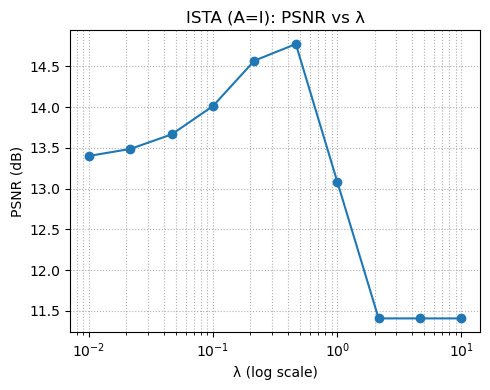

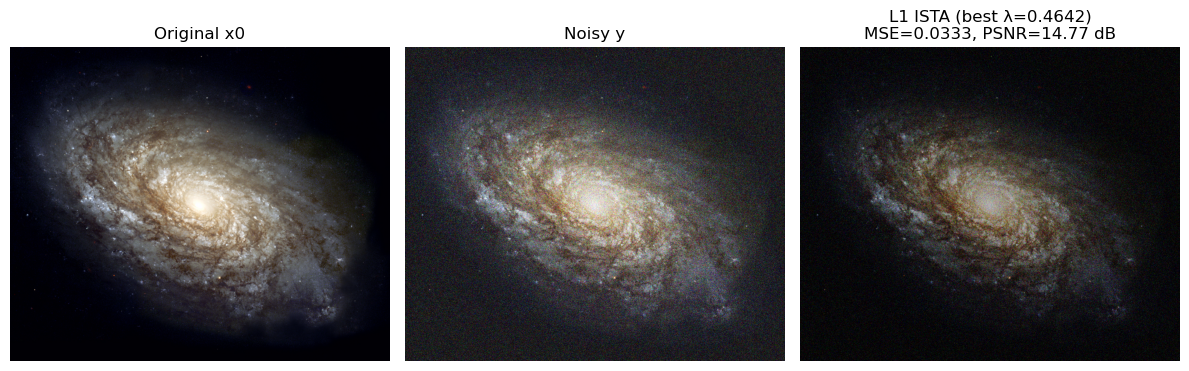

In [11]:
# Applying ISTA with A = I (just L1)

# Log-spaced sweep works well for sparsity weights on [0,1] images
lambdas = np.logspace(-2, 1, num=10)

results = []
print("Sweeping λ values...\n")
for lam in lambdas:
    x_l1, info = ista_l1_matrix(
        "I",
        y_img=y,
        lam=float(lam),
        x_shape=x0.shape,
        x_init=y,           # warm start
        max_iter=300,
        tol=1e-5,
        verbose=False
    )
    m = mse(x_l1, x0)
    p = psnr(x_l1, x0, data_range=1.0)
    results.append({"lambda": float(lam), "x": x_l1, "mse": m, "psnr": p, "iters": info["iters"], "step": info["step"]})

# Plot PSNR vs λ
plt.figure(figsize=(5,4))
plt.semilogx([r["lambda"] for r in results], [r["psnr"] for r in results], marker="o")
plt.xlabel("λ (log scale)")
plt.ylabel("PSNR (dB)")
plt.title("ISTA (A=I): PSNR vs λ")
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

# Rank by MSE (lower is better)
results.sort(key=lambda r: r["mse"])
best = results[0]
# keep the resulting image for later comparison
best_l1_image = best["x"]

# Visualize original, noisy, and best result
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(x0 if x0.ndim==3 else x0, cmap="gray" if x0.ndim==2 else None); plt.axis("off"); plt.title("Original x0")
plt.subplot(1,3,2); plt.imshow(y  if y.ndim==3  else y,  cmap="gray" if y.ndim==2  else None); plt.axis("off"); plt.title("Noisy y")
plt.subplot(1,3,3); 
plt.imshow(best["x"] if best["x"].ndim==3 else best["x"], cmap="gray" if best["x"].ndim==2 else None); 
plt.axis("off")
plt.title(f"L1 ISTA (best λ={best['lambda']:.4g})\nMSE={best['mse']:.4f}, PSNR={best['psnr']:.2f} dB")
plt.tight_layout()
plt.show()

### Sparse Denoising with an L₁ Wavelet Prior

We now solve a **sparse denoising** problem, where we now promote sparsity in the wavelet domain instead,

$$
\min_{x} \; \| y - W x \|_2^2 \;+\; \lambda \| x \|_1
$$

where $W$ is a wavelet synthesis dictionary.

Here:
- The first term keeps the reconstructed image $x$ close to the noisy observation $y$.
- The second term $ \lambda \|x\|_1 $ encourages **sparse pixel values**, effectively pushing small coefficients toward zero.
- The regularization strength $\lambda$ controls the trade-off between denoising and image preservation.

This problem has no closed-form solution (unless unitary wavelets are used), so we use the ISTA solver above. (We also need some dedicated functions to avoid computing the matrix $W$ explicitly (which would would be $\mathcal O(n^2)$ and prohibitive).

Adjoint test rel err: 1.73e-01 (should be ~1e-6 or smaller)

Adjoint test (stable) rel err: 7.71e-06
Sweeping λ for wavelet-synthesis L1...

Estimated ||A|| ≈ 1.000000, L≈2.000000, step≈0.500000
Iter   10: obj=120704.285492
Iter   20: obj=120704.785230
Iter   30: obj=120705.695597
Iter   40: obj=120706.635689
Iter   50: obj=120707.522615
Iter   60: obj=120708.355286
Iter   70: obj=120709.115992
Iter   80: obj=120709.817805
Iter   90: obj=120710.475396
Iter  100: obj=120711.093371
Estimated ||A|| ≈ 1.000000, L≈2.000000, step≈0.500000
Iter   10: obj=249554.302849
Iter   20: obj=249557.571025
Iter   30: obj=249560.085278
Iter   40: obj=249562.159207
Iter   50: obj=249563.863442
Iter   60: obj=249565.252677
Iter   70: obj=249566.423037
Iter   80: obj=249567.431335
Iter   90: obj=249568.313124
Iter  100: obj=249569.096561
Estimated ||A|| ≈ 1.000000, L≈2.000000, step≈0.500000
Iter   10: obj=413815.947075
Iter   20: obj=413816.178169
Converged at iter 28 (rel change 9.59e-06)
Estimated ||A|| 

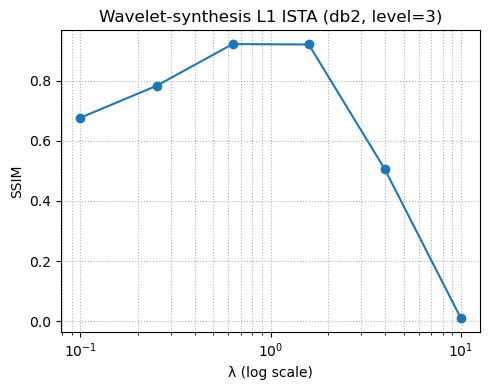

Best by SSIM: λ=0.6310 (MSE=0.005729, PSNR=22.42 dB, SSIM=0.9219)



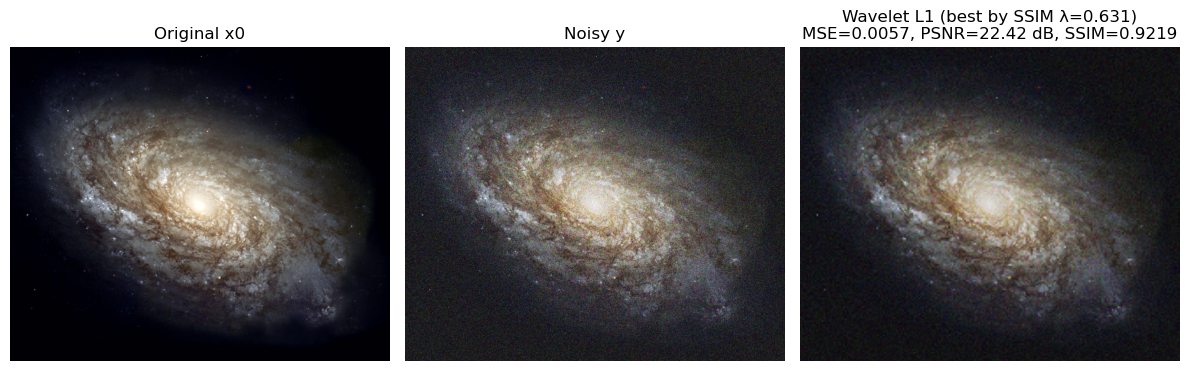

In [18]:
# Applying Wavelet Dictionaries

# ---------- Helpers Functions ----------
def analyze_to_vec(img, wavelet='db2', level=None, mode='periodization'):
    if img.ndim == 2:
        img = img[..., None]
    H, W, C = img.shape
    coeff_arrays = []
    metas = []
    for c in range(C):
        coeffs = pywt.wavedec2(img[..., c], wavelet=wavelet, level=level, mode=mode)
        arr, slices = pywt.coeffs_to_array(coeffs)
        coeff_arrays.append(arr.ravel())
        metas.append((arr.shape, slices))
    vec = np.concatenate(coeff_arrays).astype(np.float32)
    meta = {"H": H, "W": W, "C": C, "wavelet": wavelet, "level": level, "mode": mode, "metas": metas}
    return vec, meta

def synth_from_vec(vec, meta):
    H, W, C = meta["H"], meta["W"], meta["C"]
    wavelet, level, mode = meta["wavelet"], meta["level"], meta["mode"]
    metas = meta["metas"]
    out = np.zeros((H, W, C), dtype=np.float32)
    ofs = 0
    for c in range(C):
        shape_c, slices_c = metas[c]
        n_c = int(np.prod(shape_c))
        arr_c = vec[ofs:ofs+n_c].reshape(shape_c)
        ofs += n_c
        coeffs_c = pywt.array_to_coeffs(arr_c, slices_c, output_format='wavedec2')
        out[..., c] = pywt.waverec2(coeffs_c, wavelet=wavelet, mode=mode).astype(np.float32)
    return out[..., 0] if C == 1 else out

# ---------- Periodic separable convolutions ----------
def _fft_nextpow2(n):
    # small helper for decent FFT sizes (optional)
    p = 1
    while p < n:
        p <<= 1
    return p

def _circ_conv1d(x, h):
    """
    Circular 1D convolution along the last axis.
    Uses FFT for speed; h is zero-padded to len(x).
    """
    N = x.shape[-1]
    H = np.fft.rfft(np.pad(h, (0, max(0, N - len(h)))), n=N)
    X = np.fft.rfft(x, n=N, axis=-1)
    y = np.fft.irfft(X * H, n=N, axis=-1)
    return y.astype(np.float32)

def _circ_conv_rows(img, h):
    # convolve each row circularly with h
    return _circ_conv1d(img, h)

def _circ_conv_cols(img, h):
    # convolve along columns: swap axes, convolve, swap back
    tmp = _circ_conv1d(np.swapaxes(img, -2, -1), h)
    return np.swapaxes(tmp, -2, -1)

def _downsample2(x):
    # take every other sample starting at index 0
    return x[..., ::2]

def _downsample2_2d(x):
    return x[::2, ::2]

# ---------- Adjoint of synthesis (coeffs -> image) ----------
def adjoint_synthesis_to_vec(img, meta):
    """
    Compute A^T @ img, where A is your synthesis operator implemented by synth_from_vec.
    Returns a coefficient vector with the SAME packing/length as analyze_to_vec(..., meta).
    """
    H, W, C = meta["H"], meta["W"], meta["C"]
    wavelet = pywt.Wavelet(meta["wavelet"])
    level = meta["level"]
    # mode assumed 'periodization' for circular conv
    # Reconstruction filters used in synthesis:
    g0 = np.array(wavelet.rec_lo, dtype=np.float32)  # lowpass recon
    g1 = np.array(wavelet.rec_hi, dtype=np.float32)  # highpass recon
    # Transpose of circular convolution with g is circular convolution with time-reversed g
    g0t = g0[::-1]
    g1t = g1[::-1]

    if img.ndim == 2:
        img = img[..., None]

    coeff_arrays = []
    for c in range(C):
        y = img[..., c].astype(np.float32)

        # We will recursively produce (cH_l, cV_l, cD_l) for l=1..L and cA_L at the end.
        details_per_level = []
        cur = y
        for _ in range(level):
            # Apply the transposed of the synthesis "upsample+conv" blocks:
            # For adjoint, we do: convolve with g?^T then downsample by 2 along each axis.
            # Four branches give the detail coefficients at this level:
            # (low along rows/cols) -> LL ; (lo/hi)-> LH ; (hi/lo)-> HL ; (hi/hi)-> HH
            # NOTE: Order of row/col filtering must mirror waverec2's order. Here we use rows then cols.

            # LL branch
            LL = _downsample2_2d(_circ_conv_cols(_circ_conv_rows(cur, g0t), g0t))
            # LH: low rows, high cols
            LH = _downsample2_2d(_circ_conv_cols(_circ_conv_rows(cur, g0t), g1t))
            # HL: high rows, low cols
            HL = _downsample2_2d(_circ_conv_cols(_circ_conv_rows(cur, g1t), g0t))
            # HH: high rows, high cols
            HH = _downsample2_2d(_circ_conv_cols(_circ_conv_rows(cur, g1t), g1t))

            # Per PyWavelets' coeff ordering: (cH, cV, cD) corresponds to (HL, LH, HH)
            details_per_level.append( (HL, LH, HH) )

            # For the next coarser level, the "coarse" signal is LL (the adjoint maps image -> next-level approx)
            cur = LL

        cA = cur  # coarsest approximation at level L

        # Now pack into the SAME array layout PyWavelets uses.
        # wavedec2 expects [cA_L, (cH_L,cV_L,cD_L), ..., (cH_1,cV_1,cD_1)]
        coeffs_like_wavedec = [cA] + details_per_level[::-1]

        arr, slices = pywt.coeffs_to_array(coeffs_like_wavedec)
        coeff_arrays.append(arr.ravel())

    vec = np.concatenate(coeff_arrays).astype(np.float32)
    return vec

# ---------- Matrix-like operator with true adjoint ----------
class WaveletSynthesisAdjointOp:
    """
    Forward:  y = A @ c    (uses your synth_from_vec)
    Adjoint:  z = A.T @ y  (true adjoint of synthesis; NO wavedec2)
    """
    def __init__(self, H, W, C=1, wavelet='db2', level=None, mode='periodization'):
        dummy = np.zeros((H, W, C), dtype=np.float32)
        coeff_vec, meta = analyze_to_vec(dummy, wavelet=wavelet, level=level, mode=mode)
        self.meta = meta
        self.ncoeff = coeff_vec.size
        self.npix = H * W * C
        self.shape = (self.npix, self.ncoeff)

        class _Transpose:
            def __init__(self, parent):
                self.parent = parent
                self.shape = (parent.ncoeff, parent.npix)
            def __matmul__(self, img_vec):
                H, W, C = self.parent.meta["H"], self.parent.meta["W"], self.parent.meta["C"]
                img = img_vec.reshape(H, W, C) if C > 1 else img_vec.reshape(H, W)
                return adjoint_synthesis_to_vec(img, self.parent.meta)

        self.T = _Transpose(self)

    def __matmul__(self, coeff_vec):
        img = synth_from_vec(coeff_vec, self.meta)
        return img.reshape(-1)
        


# ---------- Matrix-like wavelet operator (coeffs -> image) with true adjoint ----------
class _WaveletAdjoint:
    def __init__(self, meta, ncoeff, npix):
        self.meta = meta
        self.shape = (ncoeff, npix)

    def __matmul__(self, img_vec):
        H, W, C = self.meta["H"], self.meta["W"], self.meta["C"]
        img = img_vec.reshape(H, W, C) if C > 1 else img_vec.reshape(H, W)
        coeff_vec, _ = analyze_to_vec(
            img.astype(np.float64),  # use float64 in analysis path for the test
            wavelet=self.meta["wavelet"],
            level=self.meta["level"],
            mode=self.meta["mode"]
        )
        return coeff_vec.astype(np.float64)

class WaveletSynthesisMatrix:
    def __init__(self, H, W, C=1, wavelet='db2', level=None, mode='periodization'):
        dummy = np.zeros((H, W, C), dtype=np.float64)
        coeff_vec, meta = analyze_to_vec(dummy, wavelet=wavelet, level=level, mode=mode)
        self.meta   = meta
        self.ncoeff = int(coeff_vec.size)
        self.npix   = int(H * W * C)
        self.shape  = (self.npix, self.ncoeff)
        self.T      = _WaveletAdjoint(self.meta, self.ncoeff, self.npix)

    def __matmul__(self, coeff_vec):
        img = synth_from_vec(np.asarray(coeff_vec, dtype=np.float64), self.meta)
        return img.reshape(-1).astype(np.float64)
    

# ---------- (Optional) adjointness test ----------
def check_adjoint(A_op, AT_op, n, m, trials=5, seed=0):
    rng = np.random.default_rng(seed)
    max_rel_err = 0.0
    for _ in range(trials):
        x = rng.standard_normal(n).astype(np.float32)
        y = rng.standard_normal(m).astype(np.float32)
        lhs = float((A_op @ x) @ y)   # <Ax, y>
        rhs = float(x @ (AT_op @ y))  # <x, A^T y>
        denom = max(1.0, abs(lhs), abs(rhs))
        max_rel_err = max(max_rel_err, abs(lhs - rhs) / denom)
    return max_rel_err

def check_adjoint_stable(A_op, AT_op, n, m, trials=5, seed=0):
    """
    Returns a norm-based relative error:
      |<A x, y> - <x, A^T y>| / ( ||A x||*||y|| + ||x||*||A^T y|| + 1e-12 )
    which is stable even when inner products are small.
    """
    rng = np.random.default_rng(seed)
    worst = 0.0
    for _ in range(trials):
        x = rng.standard_normal(n).astype(np.float64)
        y = rng.standard_normal(m).astype(np.float64)
        Ax  = (A_op  @ x)
        ATy = (AT_op @ y)
        lhs = float(np.dot(Ax, y))
        rhs = float(np.dot(x, ATy))
        denom = (np.linalg.norm(Ax) * np.linalg.norm(y) +
                 np.linalg.norm(x)  * np.linalg.norm(ATy) + 1e-12)
        rel = abs(lhs - rhs) / denom
        worst = max(worst, rel)
    return worst


# ---- Build A ----
H, W = x0.shape[:2]
C = 1 if x0.ndim == 2 else x0.shape[2]
wavelet = 'db2'       # try 'haar', 'db4', 'sym4', etc.
level = 3          # let pywt choose max level; or set an int like 3
mode = 'periodization'  # ensures orthonormality at boundaries for many wavelets

A_wav = WaveletSynthesisMatrix(H, W, C=C, wavelet=wavelet, level=level, mode=mode)


# ---- Check adjoint ----
rel_err = check_adjoint(A_wav, A_wav.T, n=A_wav.ncoeff, m=A_wav.npix, trials=5)
print(f"Adjoint test rel err: {rel_err:.2e} (should be ~1e-6 or smaller)\n")    

err = check_adjoint_stable(A_wav, A_wav.T, n=A_wav.ncoeff, m=A_wav.npix, trials=8)
print(f"Adjoint test (stable) rel err: {err:.2e}")   # expect ~1e-12 to 1e-9 in float64


# ---- Sweep λ and solve with ISTA ----
lambdas = np.logspace(-1, 1, num=6)
results = []
print("Sweeping λ for wavelet-synthesis L1...\n")

for lam in lambdas:
    # Note: x variable are coefficients; choose x_shape as (ncoeff,)
    x_coeffs, info = ista_l1_matrix(
        A=A_wav,
        y_img=y,                 # y is the image (measurement space)
        lam=float(lam),
        x_shape=(A_wav.ncoeff,), # ISTA will return coeff vector shaped (ncoeff,)
        x_init=None,             # defaults to A.T @ y (wavelet analysis)
        max_iter=100,
        step=None,               # let ISTA estimate spectral norm
        tol=1e-5,
        clip01=False,            # DO NOT clip coefficients
        verbose=True
    )
    # Reconstruct image from coeffs to evaluate image-domain error
    x_img = (A_wav @ x_coeffs.reshape(-1)).reshape(x0.shape)
    x_img = np.clip(x_img, 0.0, 1.0)

    m = mse(x_img, x0)
    p = psnr(x_img, x0)
    s = ssim(x_img, x0, data_range=1.0, win_size=win_size, channel_axis=-1) if C > 1 else ssim(x_img, x0, data_range=1.0, win_size=win_size)   
    results.append({"lambda": float(lam), "xcoeff": x_coeffs, "ximg": x_img, "mse": m, "psnr": p, "iters": info["iters"], "ssim": s})

# ---- Plot PSNR vs λ ----
plt.figure(figsize=(5,4))
plt.semilogx([r["lambda"] for r in results], [r["ssim"] for r in results], marker="o")
plt.xlabel("λ (log scale)")
plt.ylabel("SSIM")
plt.title(f"Wavelet-synthesis L1 ISTA ({wavelet}, level={level})")
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

# pick the results by ssim
results.sort(key=lambda r: r["ssim"], reverse=True)
best_ssim = results[0]
print(f"Best by SSIM: λ={best_ssim['lambda']:.4f} "
      f"(MSE={best_ssim['mse']:.6f}, PSNR={best_ssim['psnr']:.2f} dB, SSIM={best_ssim['ssim']:.4f})\n") 

# keep the resulting image for later comparison
best_wavelet_image = best_ssim["ximg"]

# display best by SSIM
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(x0 if C>1 else x0, cmap=None if C>1 else "gray"); plt.axis("off"); plt.title("Original x0")
plt.subplot(1,3,2); plt.imshow(y  if C>1 else y,  cmap=None if C>1 else "gray"); plt.axis("off"); plt.title("Noisy y")
plt.subplot(1,3,3); plt.imshow(best_ssim["ximg"] if C>1 else best_ssim["ximg"], cmap=None if C>1 else "gray"); plt.axis("off")
plt.title(f"Wavelet L1 (best by SSIM λ={best_ssim['lambda']:.3g})\nMSE={best_ssim['mse']:.4f}, PSNR={best_ssim['psnr']:.2f} dB, SSIM={best_ssim['ssim']:.4f}")
plt.tight_layout()
plt.show()  

### Total Variation (TV) Denoising

**Total Variation denoising** encourages piecewise-smooth images while preserving sharp edges.  
The model seeks an image $x$ that minimizes

$$
\min_{x} \; \|x - y\|_2^2 \;+\; \lambda \, \|\nabla x\|_1
$$

where:
- The first term enforces **data fidelity**, keeping $x$ close to the noisy observation $y$.
- The second term penalizes the **total variation** of $x$, measured as the $\ell_1$-norm of its spatial gradients  
  (i.e., $\|\nabla x\|_1 = \sum_{i,j} |(\nabla_x x)_{i,j}| + |(\nabla_y x)_{i,j}|$).

The parameter $\lambda > 0$ controls the trade-off:
- Small $\lambda$ → less smoothing, more noise remains.  
- Large $\lambda$ → stronger smoothing, sharper edges are preserved but fine details may be lost.

This problem has no closed-form solution.  
However, it can be efficiently solved using a variety of **first-order optimization methods**, such as **Primal–Dual (Chambolle–Pock)** algorithms, or  **ADMM** (Alternating Direction Method of Multipliers).


Sweeping λ for TV denoising...



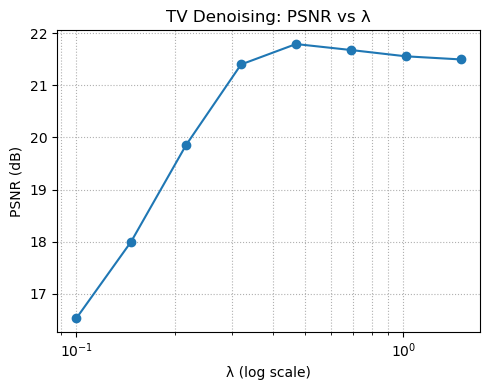

Best: λ=0.4700  MSE=0.006618  PSNR=21.79 dB


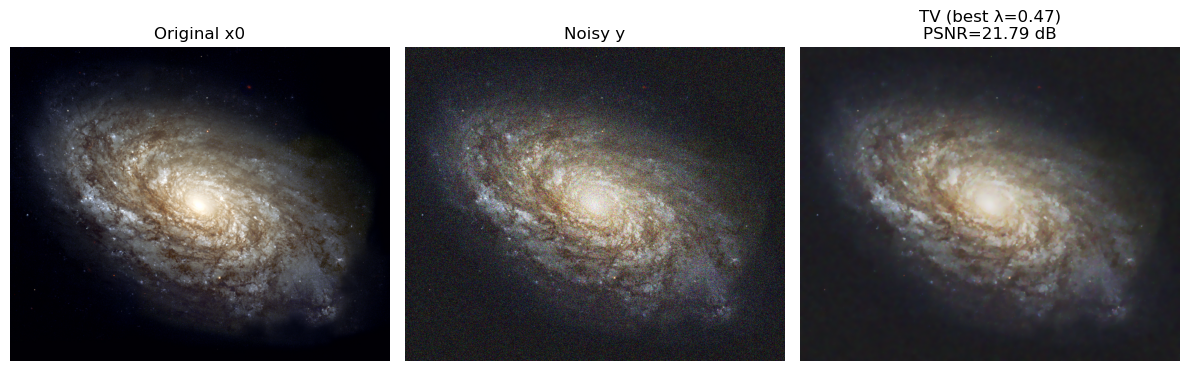

In [19]:
# TV Denoising

# ---------- finite differences (forward) and matching divergence ----------
def grad_forward(x):
    """Forward differences with Neumann BC (zero gradient at image border)."""
    gx = np.zeros_like(x, dtype=np.float32)
    gy = np.zeros_like(x, dtype=np.float32)
    gx[:, :-1] = x[:, 1:] - x[:, :-1]   # forward in x
    gy[:-1, :] = x[1:, :] - x[:-1, :]   # forward in y  (FIXED SIGN)
    return gx, gy

def div_backward(px, py):
    """Divergence (adjoint of grad_forward with matching BC)."""
    div = np.zeros_like(px, dtype=np.float32)
    # x-component: p[i,j] - p[i,j-1]
    div[:, :-1] +=  px[:, :-1]
    div[:,  1:] += -px[:, :-1]
    # y-component: q[i,j] - q[i-1,j]
    div[:-1, :] +=  py[:-1, :]
    div[ 1:, :] += -py[:-1, :]
    return div

def mse(a, b): return float(np.mean((a - b)**2))
def psnr(a, b, data_range=1.0):
    m = mse(a, b)
    return float('inf') if m == 0 else 10.0 * np.log10((data_range**2) / m)

# --------------------- Chambolle–Pock TV denoiser -------------------------
def tv_denoise_cp(
    y, lam=0.1, max_iter=300, tau=0.25, sigma=0.25, theta=1.0,
    isotropic=True, record_every=20, verbose=False, clip01=True):
    """
    Solve:  min_x  ||x - y||_2^2  + lam * TV(x)
    where TV is isotropic (default) or anisotropic.

    Stability condition: tau * sigma * ||K||^2 < 1.
    For forward differences, ||K||^2 <= 8, so tau = sigma = 0.25 is safe (0.25*0.25*8 = 0.5 < 1).
    """
    single = (y.ndim == 2)
    if single: y = y[..., None]
    H, W, C = y.shape

    # variables
    x  = y.astype(np.float32).copy()
    xb = x.copy()
    px = np.zeros_like(y, dtype=np.float32)  # dual horizontal
    py = np.zeros_like(y, dtype=np.float32)  # dual vertical

    # prox of data term g(x) = ||x - y||^2  (note: no 1/2 factor)
    def prox_g(z):
        return (z + 2.0 * tau * y) / (1.0 + 2.0 * tau)

    obj_hist = []

    for k in range(1, max_iter + 1):
        # ----- Dual ascent + projection -----
        for c in range(C):
            gx, gy = grad_forward(xb[..., c])
            px[..., c] += sigma * gx
            py[..., c] += sigma * gy

            if isotropic:
                # project each (px,py) vector onto l2 ball of radius lam
                nrm = np.sqrt(px[..., c]**2 + py[..., c]**2)
                scale = np.maximum(1.0, nrm / (lam + 1e-12))
                px[..., c] /= scale
                py[..., c] /= scale
            else:
                # anisotropic: componentwise clamp to [-lam, lam]
                px[..., c] = np.clip(px[..., c], -lam, lam)
                py[..., c] = np.clip(py[..., c], -lam, lam)

        # ----- Primal update -----
        x_prev = x.copy()
        div_p = np.zeros_like(x)
        for c in range(C):
            div_p[..., c] = div_backward(px[..., c], py[..., c])
        x = prox_g(x + tau * div_p)

        # ----- Extrapolation -----
        xb = x + theta * (x - x_prev)

        # ----- Bookkeeping -----
        if (k == 1) or (k % record_every == 0):
            data = np.sum((x - y)**2)
            if isotropic:
                tv_val = 0.0
                for c in range(C):
                    gx, gy = grad_forward(x[..., c])
                    tv_val += np.sum(np.sqrt(gx**2 + gy**2))
            else:
                tv_val = 0.0
                for c in range(C):
                    gx, gy = grad_forward(x[..., c])
                    tv_val += np.sum(np.abs(gx)) + np.sum(np.abs(gy))
            obj = float(data + lam * tv_val)
            obj_hist.append(obj)
            if verbose:
                print(f"Iter {k:4d}: obj={obj:.6f}, data={data:.6f}, tv={tv_val:.6f}")

    if clip01: x = np.clip(x, 0.0, 1.0)
    if single: x = x[..., 0]
    return x, {"obj": obj_hist, "iters": k}

# -------------------------- Example usage --------------------------
# Assumes x0 (clean) and y (noisy in [0,1]) already exist.

lambdas = np.geomspace(0.1, 1.5, 8)   # broader, effective range for σ≈0.078
results = []
print("Sweeping λ for TV denoising...\n")
for lam in lambdas:
    x_tv, info = tv_denoise_cp(
        y, lam=float(lam),
        max_iter=300,
        tau=0.25, sigma=0.25, theta=1.0,
        isotropic=True,          # try True first; set False to compare
        record_every=25, verbose=False
    )
    results.append({
        "lambda": float(lam),
        "x": x_tv,
        "mse": mse(x_tv, x0),
        "psnr": psnr(x_tv, x0, data_range=1.0)
    })


# plot PSNR vs λ
plt.figure(figsize=(5,4))
plt.semilogx([r["lambda"] for r in results], [r["psnr"] for r in results], marker="o")
plt.xlabel("λ (log scale)")
plt.ylabel("PSNR (dB)")
plt.title("TV Denoising: PSNR vs λ")
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

# Pick best by PSNR (or MSE)
results.sort(key=lambda r: r["psnr"], reverse=True)
best = results[0]
print(f"Best: λ={best['lambda']:.4f}  MSE={best['mse']:.6f}  PSNR={best['psnr']:.2f} dB")

# keep the resulting image for later comparison
best_tv_image = best["x"]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(x0 if x0.ndim==3 else x0, cmap=None if x0.ndim==3 else "gray"); plt.axis("off"); plt.title("Original x0")
plt.subplot(1,3,2); plt.imshow(y  if y.ndim==3  else y,  cmap=None if y.ndim==3  else "gray"); plt.axis("off"); plt.title("Noisy y")
plt.subplot(1,3,3); plt.imshow(best["x"] if best["x"].ndim==3 else best["x"], cmap=None if best["x"].ndim==3 else "gray"); plt.axis("off")
plt.title(f"TV (best λ={best['lambda']:.3g})\nPSNR={best['psnr']:.2f} dB")
plt.tight_layout(); plt.show()

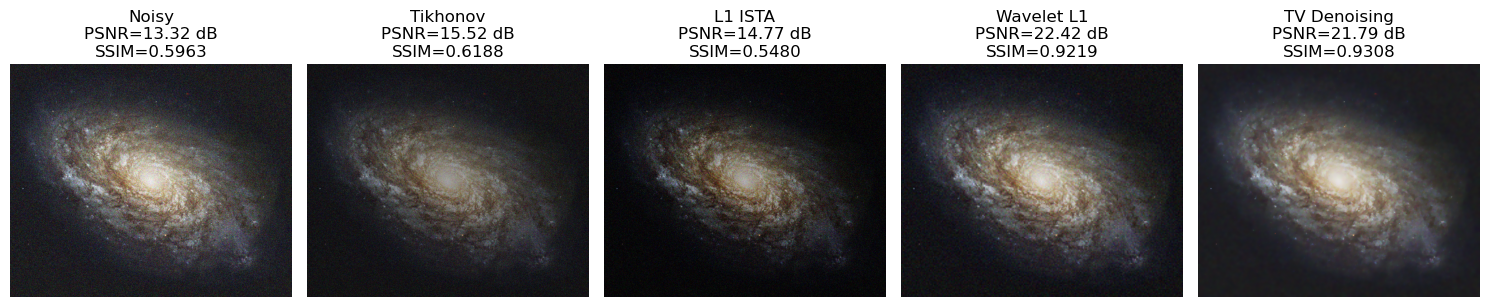

In [20]:
# Gathering Results

# Display all best results side by side for comparison with respective PSNR and SSIM
methods = [
    ("Noisy", y, psnr(y, x0), ssim(y, x0, data_range=1.0, win_size=win_size, channel_axis=-1) if x0.ndim==3 else ssim(y, x0, data_range=1.0, win_size=win_size)),
    ("Tikhonov", best_tik_image, psnr(best_tik_image, x0), ssim(best_tik_image, x0, data_range=1.0, win_size=win_size, channel_axis=-1) if x0.ndim==3 else ssim(best_tik_image, x0, data_range=1.0, win_size=win_size)),
    ("L1 ISTA", best_l1_image, psnr(best_l1_image, x0), ssim(best_l1_image, x0, data_range=1.0, win_size=win_size, channel_axis=-1) if x0.ndim==3 else ssim(best_l1_image, x0, data_range=1.0, win_size=win_size)),
    ("Wavelet L1", best_wavelet_image, psnr(best_wavelet_image, x0), ssim(best_wavelet_image, x0, data_range=1.0, win_size=win_size, channel_axis=-1) if x0.ndim==3 else ssim(best_wavelet_image, x0, data_range=1.0, win_size=win_size)),
    ("TV Denoising", best_tv_image, psnr(best_tv_image, x0), ssim(best_tv_image, x0, data_range=1.0, win_size=win_size, channel_axis=-1) if x0.ndim==3 else ssim(best_tv_image, x0, data_range=1.0, win_size=win_size))
]
plt.figure(figsize=(15, 5))
for i, (name, img, p, s) in enumerate(methods):
    plt.subplot(1, len(methods), i + 1)
    plt.imshow(img if img.ndim==3 else img, cmap=None if img.ndim==3 else "gray")
    plt.axis("off")
    plt.title(f"{name}\nPSNR={p:.2f} dB\nSSIM={s:.4f}")
plt.tight_layout()
plt.show()
